# **EXPLORATORY DATA ANALYSIS**

In [56]:
import os
import PIL
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import pandas as pd
import seaborn as sns


In [57]:
# declare the original directory path for the lunar images
data_dir = Path('drive/MyDrive/MoonImages/')
image_dir = data_dir / 'render'
mask_dir = data_dir / 'clean'
#create a list of all the files in the folder
image_file_list = os.listdir(image_dir)
mask_file_list = os.listdir(mask_dir)

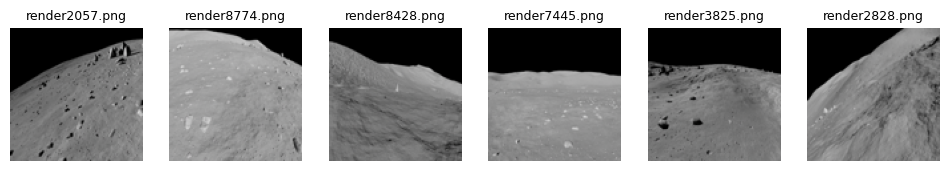

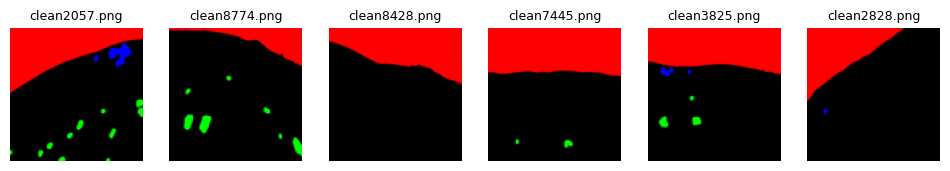

In [58]:
w = 6
h = 1

random_image_list = np.random.choice(image_file_list, size=w*h, replace=False).tolist()
random_mask_list = [filename.replace('render', 'clean') for filename in random_image_list]


"""
This function uses the open, resize and array functions to manage data visualizations
input:
  im_dir - directory of images
  im_file - name of image file
output:
  image - numpy array of image
"""
def load_img(im_dir, im_file):
  #resize the images with a 100x100 shape
  return np.array(PIL.Image.open(im_dir / im_file).resize((100, 100)))



# define a grid of (w, h)
_, axes_list = plt.subplots(h, w, figsize=(2*w, 2*h))

# display images
for axes in axes_list:
    axes.axis('off')
    image_file = random_image_list.pop()
    axes.imshow(load_img(image_dir, image_file)) # load and show
    axes.set_title(image_file, fontsize=9) # show the filename

# display masks corresponding to the images
_, axes_list = plt.subplots(h, w, figsize=(2*w, 2*h))
for axes in axes_list:
    axes.axis('off')
    mask_file = random_mask_list.pop()
    axes.imshow(load_img(mask_dir, mask_file)) # load and show
    axes.set_title(mask_file, fontsize=9) # show the filename

UTILITY FUNCTIONS

In [59]:
"""
Counts the pixels in the mask images
input:
  image_list - list of image names
  image_dir - directory of images
output:
  pixel_counts - dataframe of pixel counts for each image
"""
def count_pixels(image_list, image_dir):
    pixel_counts = {}
    for image_name in image_list:
        image_path = image_dir / image_name
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Failed to load image: {image_path}")
            continue

        flattened_img = img.flatten()
        unique_pixels, counts = np.unique(flattened_img, return_counts=True)

        for pixel, count in zip(unique_pixels, counts):
            if pixel not in pixel_counts:
                pixel_counts[pixel] = {}
            pixel_counts[pixel][image_name] = count.astype(int)

    df = pd.DataFrame(pixel_counts).fillna(0)  # Fill missing values with 0 and transpose
    return df


"""
Calculates the class distribution for each image
input:
  pixel_df - dataframe of pixel counts for each image
output:
  class_distribution_df - dataframe of class distribution for each image
"""
def class_distribution(pixel_df):
  class_distribution_df = pd.DataFrame()
  for col in pixel_df.columns:
      class_distribution_df[col] = pixel_df[col].apply(lambda x: 1 if x > 0 else x)

  class_distribution_df.rename(columns={0: 'surface', 76: 'sky', 29: 'big_rocks', 149: 'small_rocks'}, inplace=True)
  return class_distribution_df

In [60]:
# declare the working directory for the train test split folders
working_dir = working_dir = Path('drive/MyDrive/MoonWorking/') #Path('.')
train_dir = working_dir / 'train'
test_dir = working_dir / 'test'
val_dir = working_dir / 'val'

In [61]:
# build image list, mask list and directory paths
training_image_list = os.listdir(train_dir/'images')
testing_image_list = os.listdir(test_dir/'images')
validation_image_list = os.listdir(val_dir/'images')

training_mask_list = os.listdir(train_dir/'masks')
testing_mask_list = os.listdir(test_dir/'masks')
validation_mask_list = os.listdir(val_dir/'masks')

training_mask_dir = train_dir/'masks'
testing_mask_dir = test_dir/'masks'
validation_mask_dir = val_dir/'masks'

In [62]:
#create dataframe to count the pixels in each mask for train, test, and validation
training_pixel_df = count_pixels(image_list=training_mask_list, image_dir=training_mask_dir)
testing_pixel_df = count_pixels(image_list=testing_mask_list, image_dir=testing_mask_dir)
validation_pixel_df = count_pixels(image_list=validation_mask_list, image_dir=validation_mask_dir)

In [63]:
#distribution of images with value of 1 if a pixel of that value exists.
training_class_distribution_df = class_distribution(pixel_df=training_pixel_df)
testing_class_distribution_df = class_distribution(pixel_df=testing_pixel_df)
validation_class_distribution_df = class_distribution(pixel_df=validation_pixel_df)

**DISPLAY CLASS DISTRIBUTION IN TRAINING, TEST, AND VALIDATION SETS**

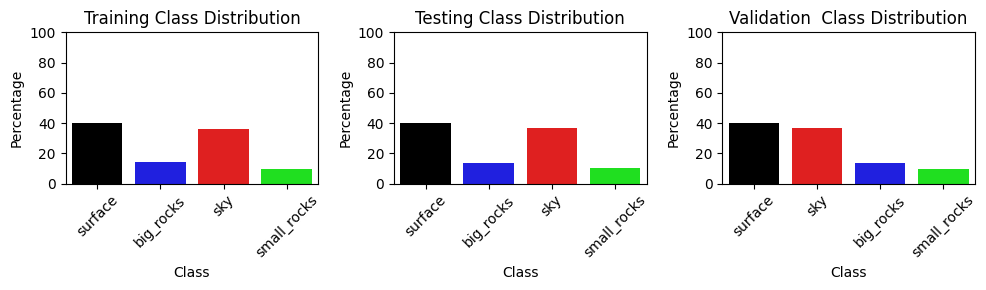

In [73]:
#calculate percentages
training_class_percentages = (training_class_distribution_df.sum() / training_class_distribution_df.sum().sum()) * 100
testing_class_percentages = (testing_class_distribution_df.sum() / testing_class_distribution_df.sum().sum()) * 100
validation_class_percentages = (validation_class_distribution_df.sum() / validation_class_distribution_df.sum().sum()) * 100

# Assuming 'surface', 'sky', 'big_rocks', and 'small_rocks' are your class labels
color_palette = {'sky': 'red', 'surface': 'black', 'big_rocks': 'blue', 'small_rocks': 'lime'}

w=3
h = 1
fig, axes_list = plt.subplots(h, w, figsize=(10, 3))

# Plot on different axes objects
sns.barplot(x=training_class_percentages.index,
            y=training_class_percentages.values,
            hue=training_class_percentages.index,
            palette=color_palette,
            ax=axes_list[0])
axes_list[0].set_title('Training Class Distribution')
axes_list[0].set_xlabel('Class') # Set labels for each subplot
axes_list[0].set_ylabel('Percentage')
axes_list[0].set_xticks(axes_list[0].get_xticks())
axes_list[0].set_xticklabels(axes_list[0].get_xticklabels(), rotation=45)
axes_list[0].set_ylim(0, 100)

sns.barplot(x=testing_class_percentages.index,
            y=testing_class_percentages.values,
            hue=testing_class_percentages.index,
            palette = color_palette,
            ax=axes_list[1])
axes_list[1].set_title('Testing Class Distribution')
axes_list[1].set_xlabel('Class')
axes_list[1].set_ylabel('Percentage')
axes_list[1].set_xticks(axes_list[1].get_xticks())
axes_list[1].set_xticklabels(axes_list[1].get_xticklabels(), rotation=45)
axes_list[1].set_ylim(0, 100)

sns.barplot(x=validation_class_percentages.index,
            y=validation_class_percentages.values,
            hue=validation_class_percentages.index,
            palette=color_palette,
            ax=axes_list[2])
axes_list[2].set_title('Validation  Class Distribution')
axes_list[2].set_xlabel('Class')
axes_list[2].set_ylabel('Percentage')
axes_list[2].set_xticks(axes_list[2].get_xticks())
axes_list[2].set_xticklabels(axes_list[2].get_xticklabels(), rotation=45)
axes_list[2].set_ylim(0, 100)

plt.tight_layout() # Adjust layout for better spacing
plt.show()


The Training Class Distribution contains larger samples of Surface and Sky and fewer samples of rocks. An imbalanced class distribution makes it difficult to train the model to segment big rocks and small rocks correctly. We will use techniques to augment the distribution of rocks.